# Pink Noise Generation
Generation of pink $(\frac{1}{f})$ noise using a white noise generator in conjunction with a pinking filter.


In [237]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

Set sequence length $N$ and sampling rate $f_s$.

In [238]:
N = 2**16
f_s = 44100

Robert Bristow-Johnson found a simple 3rd order equiripple approximation to the ideal pinking (-3 dB/octave) filter, by alternating real poles with real zeros:

$H(z)=\frac{(z - z_0)(z - z_1)(z - z_2)}{(z - p_0)(z - p_1)(z - p_2)}$

|$n$|$p_n$|$z_n$|
|-|---|---|
|0|0.99572754|0.98443604|
|1|0.94790649|0.83392334|
|2|0.53567505|0.07568359|


In [239]:
p = np.array((0.99572754, 0.94790649, 0.53567505))
z = np.array((0.98443604, 0.83392334, 0.07568359))

Expanding $H(z)$ for direct II transposed implementation gives:

$H(z)=\frac{1-(z_0+z_1+z_2)z^{-1}+(z_0z_1+z_0z_2+z_1z_2)z^{-2}-z_0z_1z_2z^{-3}}{1-(p_0+p_1+p_2)z^{-1}+(p_0p_1+p_0p_2+p_1p_2)z^{-2}-p_0p_1p_2z^{-3}}$

In [240]:
a = np.array([1, -(p[0] + p[1] + p[2]), (p[0]*p[1] +
                                         p[1]*p[2] + p[0]*p[2]), -(p[0]*p[1]*p[2])])
b = np.array([1, -(z[0] + z[1] + z[2]), (z[0]*z[1] +
                                         z[1]*z[2] + z[0]*z[2]), -(z[0]*z[1]*z[2])])
print(b, a)

[ 1.         -1.89404297  0.95856416 -0.062132  ] [ 1.         -2.47930908  1.98501285 -0.50560043]


Calculate and display filter frequency repsonse.

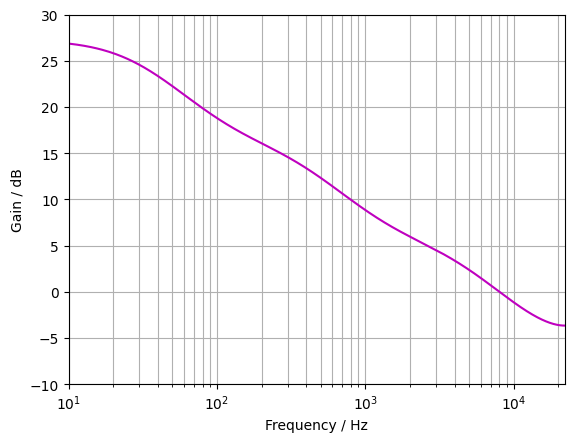

In [241]:
w, h = signal.freqz(b, a, worN=N//2, fs=f_s)
fig, ax = plt.subplots()
ax.semilogx(w, 20 * np.log10(abs(h)), 'm')
ax.set_xlim(10, f_s // 2)
ax.set_ylim(-10, 30)
ax.set_xlabel('Frequency / Hz')
ax.set_ylabel('Gain / dB')
ax.grid(which='both')

Calculate coefficient for unity gain over full bandwidth.

In [242]:
k = 1.0 / np.sqrt(np.sum(np.square(np.abs(h))) / len(h))
print(k)

0.5748832615744771


Generate white noise and apply pinking filter.

In [243]:
rng = np.random.default_rng()
white = 2 * rng.uniform(size=N) - 1
pink = k * signal.lfilter(b, a, white)

Take FFTs and plot amplitude spectrum.

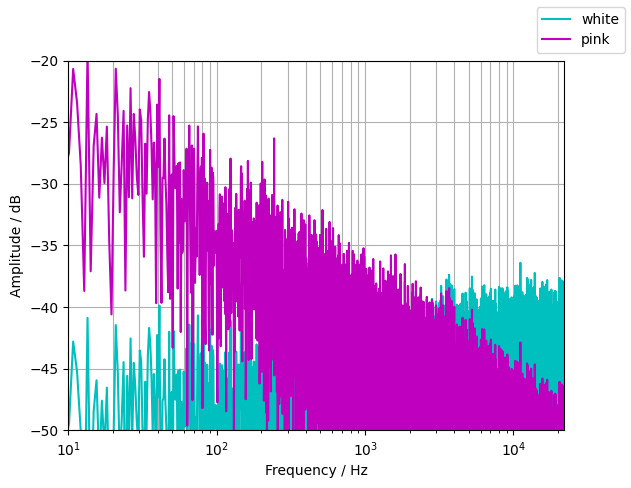

In [244]:
Hw = np.fft.rfft(white)
Hp = np.fft.rfft(pink)
fig, ax = plt.subplots()
ax.semilogx(w, 20 * np.log10(2 * np.abs(Hw[:-1]) / N), 'c',
            w, 20 * np.log10(2 * np.abs(Hp[:-1]) / N), 'm')
ax.set_xlim(10, f_s // 2)
ax.set_ylim(-50, -20)
ax.set_xlabel('Frequency / Hz')
ax.set_ylabel('Amplitude / dB')
ax.grid(which='both')
fig.legend(('white', 'pink'));